In [59]:
import vision_util as vs
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [60]:
ret, img1 = vs.get_video_capture_frame('cr1.jpg')
ret, img2 = vs.get_video_capture_frame('cr2.jpg')
ret, img3 = vs.get_video_capture_frame('cr3.jpg')
ret, img4 = vs.get_video_capture_frame('cr4.jpg')
ret, img5 = vs.get_video_capture_frame('cal_pos.jpg')

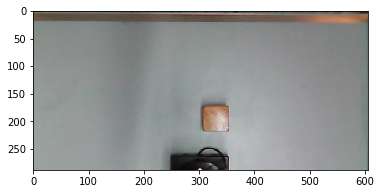

In [63]:
crop = img5[52:img4.shape[0]-140, 32:img4.shape[1]-2]
plt.imshow(crop)

First the image is cropped to avoid noise outside of the table. The Crustcrawler has a base with the a width of 11.5 cm. In order to later translate the pixel width of the image into centimeter we are going to use it for calibration. This could also be done with another distinct visual marker.

115.99998474121094
((1.5, 141.5), (5.0, 3.0), -90.0)
((548.5, 36.5), (7.0, 3.0), -0.0)
((229.5, 32.5), (1.0, 1.0), -90.0)
((296.5, 25.5), (1.0, 1.0), -90.0)
((409.5, 22.5), (1.0, 1.0), -90.0)
((628.1065673828125, 37.651878356933594), (29.537311553955078, 46.60813903808594), -55.61965560913086)
((571.0000610351562, 21.000001907348633), (4.242640495300293, 2.8284268379211426), -45.0)
((375.5, 18.5), (1.0, 1.0), -90.0)
((148.01722717285156, 20.79309844970703), (7.984899520874023, 5.199469566345215), -21.801410675048828)
((477.5, 17.5), (1.0, 1.0), -90.0)
((460.5, 12.5), (1.0, 1.0), -90.0)
((427.0, 18.5), (15.0, 6.0), -90.0)
((539.067626953125, 9.09459400177002), (8.38434886932373, 3.452378749847412), -80.53767395019531)
((637.0, 1.5), (3.0, 4.0), -90.0)
((401.5, 3.5), (3.0, 7.0), -0.0)
((384.0, 7.5), (15.0, 10.0), -90.0)
((367.0, 4.0), (2.0, 8.0), -0.0)
((347.443115234375, 9.701316833496094), (21.56467056274414, 23.716459274291992), -10.784297943115234)
((381.0, 24.5), (308.0, 49.0), -0.0

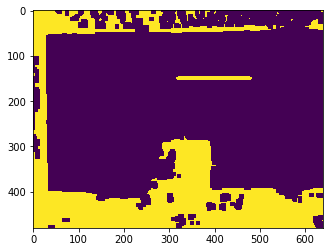

In [57]:
class Crustcrawler:
    x1 = 0
    x2 = 0
    base_pixel_width = 0

'''
Hue mask
'''
def crustcrawler_mask(img_frame):
    result = img_frame       
    result = cv2.cvtColor(result, cv2.COLOR_BGR2HSV)
    lower_rgb = np.array([0,0,0])
    upper_rgb = np.array([120,120,90])
    result = cv2.inRange(result, lower_rgb, upper_rgb)

    ret, result = cv2.threshold(result, 50, 255, cv2.THRESH_BINARY)
    return result

'''
'''
def filter_crustcrawler(img_frame):
    frame = img_frame
    frame = crustcrawler_mask(frame)
    frame = vs.remove_noise(frame)
    return frame

def find_crustcrawler_pixel_width(img_frame):
    frame = img_frame
    contours, hierarchy = cv2.findContours(frame.astype('uint8'), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    crustcrawler = Crustcrawler()
    
    for contour in contours:
        pixel_areal = cv2.contourArea(contour)
        rectangle_w_rotation = cv2.minAreaRect(contour) # use the one without rotation
        crustcrawler.x1 = rectangle_w_rotation[0][0]
        crustcrawler.x2 = rectangle_w_rotation[1][0]
        print(rectangle_w_rotation)    
    
    return crustcrawler, frame
    
crust = filter_crustcrawler(crop)
print(base.x2)
base, frame = find_crustcrawler_pixel_width(crust)

#rgb_img = cv2.cvtColor(binary_img, cv.CV_GRAY2RGB)
cv2.line(frame, (int(base.x1),150), (int(base.x2), 150), (255,255,255), thickness=8)
print(base)
plt.imshow(frame)

In [ ]:
cropped_img = img[52:img.shape[0]-197, 28:img.shape[1]-2]

plt.imshow(cropped_img)

In [ ]:
plt.imshow(img2)

In [ ]:
plt.imshow(img3)

In [ ]:
def find_brick_centers(img_frame):
    frame = img_frame
    contours, hierarchy = cv2.findContours(frame.astype('uint8'), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    brick_arr = []
    for contour in contours:
        pixel_areal = cv2.contourArea(contour)
        if(pixel_areal > 1500):
            brick = Brick()
            M = cv2.moments(contour)
            brick.x_center = int(M['m10']/M['m00'])
            brick.y_center = int(M['m01']/M['m00'])
            rectangle_w_rotation = cv2.minAreaRect(contour)
            brick.pixel_width = rectangle_w_rotation[1][0]
            brick.pixel_height = rectangle_w_rotation[1][1]
            brick.rotation_degrees = rectangle_w_rotation[2]
            #box_points = cv2.cv.BoxPoints(rectangle_w_rotation)
            #print(rectangle_w_rotation)
            print(brick.rotation_degrees)
            #print(brick.pixel_width)
            #print(brick.pixel_height)
            brick_arr.append(brick)
            # frame = cv2.circle(frame,(cx, cy),10,(0,255,0))
            # cv2.imshow('blue', frame)
        elif(pixel_areal > 600):
            brick = Brick()
            M = cv2.moments(contour)
            brick.x_center = int(M['m10']/M['m00'])
            brick.y_center = int(M['m01']/M['m00'])
            brick_arr.append(brick)
            #result = cv2.circle(result,(cx, cy),5,(0,255,0))
    return brick_arr